In [110]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

from blockchain import util
util.TIMEOUT = 20

In [111]:
#reading in data
from blockchain import blockexplorer
from blockutils import BlockUtils
import numpy as np 
#estimation
from matplotlib import pyplot as plt
import itertools
import seaborn as sns;
import scipy
from numpy import inf
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import mielke
from scipy.stats import iqr

In [112]:
#latest = blockexplorer.get_block(blockexplorer.get_latest_block().hash)
#latest = blockexplorer.get_block("0000000000000000000857fad93ae6e401153a94f06c4b5adfb733f20a6c13b1")

In [113]:
#Downloads and writes n blocks from the given block to disk
#fromBlocks - hash of a highest block 
def fetch_blocks(fromBlock,n):
    butils = BlockUtils()
    butils.clear()
    status = butils.writeBlock(fromBlock.json)
    blocks = [fromBlock]
    prev = []
    prevHash = None
    for i in range(0,50):
        prevHash=blocks[0].previous_block
        b = blockexplorer.get_block(prevHash)
        blocks.insert(0,b)
        status = vbutils.writeBlock(b.json)
        prev = b.previous_block
    #return blocks

In [67]:
#load blocks for disk
butils = BlockUtils()
blocks = butils.getBlock()

In [114]:
txs=[block.transactions for block in blocks]

In [115]:
#alt[0] ----> neu[-1]
#transaction data
times=[]
for alltx in txs:
    times.append([tx.time for tx in alltx])
timesDelta = []
for pos in range(0,len(times)):
    timesDelta.append([blocks[pos].time - txtime for txtime in times[pos]])
sizes = []
for alltx in txs:
    sizes.append([tx.size for tx in alltx])
fees = []
for alltx in txs:
    fees.append([tx.fee for tx in alltx])

In [116]:
#price per byte
npSizes = np.array(sizes)
npFees = np.array(fees)
pricePerByte = [np.divide(npFees[i],npSizes[i]) for i in range(0,len(npFees))]

In [117]:
iqrFees = [iqr(pricePerByte[i]) for i in range(0,len(pricePerByte))]
medianFees = [np.median(pricePerByte[i]) for i in range(0,len(pricePerByte))]
#median + iqr and median -iqr
mpiqr = [medianFees[i]+iqrFees[i] for i in range(0,len(iqrFees))]
mmpiqr = [medianFees[i]-iqrFees[i] for i in range(0,len(iqrFees))]

In [118]:
#estimation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

In [119]:
def estimateLinReg(inputData,polyn):
    inputData=np.array(inputData)
    inputData = inputData.reshape(-1, 1)
    y_train, y_test = train_test_split(inputData, test_size=0.3, random_state=0)
    x_train = np.array(list(range(0,len(y_train)))).reshape(-1,1)
    x_test = np.array(list(range(0,len(y_test)))).reshape(-1,1)
    
    degree=polyn
    linReg=make_pipeline(PolynomialFeatures(degree),LinearRegression());
    linReg.fit(x_train,y_train);
    linReg.score(x_test,y_test);
    return linReg

In [120]:
#estimate median
avgFeeMod = estimateLinReg(medianFees,1)
#estimate iqr+
maxFeeMod = estimateLinReg(mpiqr,1)
#estimate iqr-
minFeeMod = estimateLinReg(mmpiqr,1)

In [121]:
avgFee = avgFeeMod.predict(np.array(list(range(0,len(medianFees)+1))).reshape(-1,1))
maxFee = maxFeeMod.predict(np.array(list(range(0,len(mpiqr)+1))).reshape(-1,1))
minFee = minFeeMod.predict(np.array(list(range(0,len(mmpiqr)+1))).reshape(-1,1))

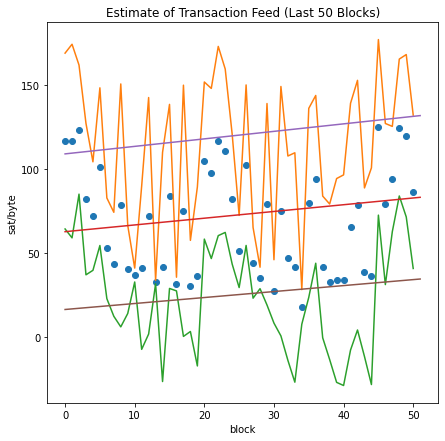

In [122]:
plt.figure(figsize=(7,7))
plt.title("Estimate of Transaction Feed (Last 50 Blocks)")
plt.ylabel("sat/byte")
plt.xlabel("block")
#plt.grid(True)
plt.plot(medianFees,'o')
plt.plot(mpiqr)
plt.plot(mmpiqr)
plt.plot(avgFee);
plt.plot(maxFee);
plt.plot(minFee);

In [123]:
#Recommended Transcation cost for next block
print("Max: ",maxFee[-1])
print("Average: ",avgFee[-1])
print("Min: ",minFee[-1])

Max:  [131.6206986]
Average:  [83.133183]
Min:  [34.6456674]


<Figure size 432x288 with 0 Axes>

<AxesSubplot:ylabel='Density'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:ylabel='Density'>

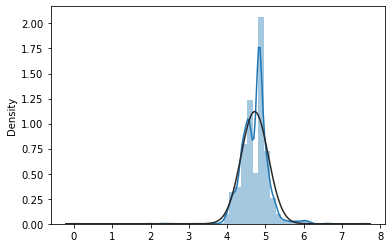

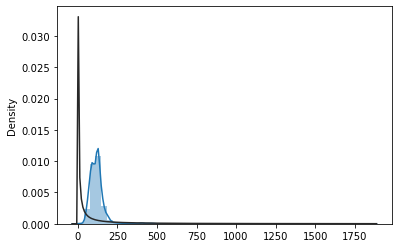

In [124]:
plt.figure()
ppbLn=np.log(pricePerByte[2])
ppbLn[ppbLn == inf] = 0
ppbLn[ppbLn == -inf] = 0
sns.distplot(ppbLn,fit=norm)
plt.figure()
sns.distplot(pricePerByte[2], fit=lognorm)

In [128]:
confidence_level = 0.95
degrees_freedom = len(pricePerByte[2]) - 1
sample_mean = np.median(pricePerByte[2])
sample_mean
sample_standard_error = scipy.stats.sem(pricePerByte[2])
confidence_interval = scipy.stats.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)

123.31510680360674